In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import os.path as osp
import xarray as xr
import sys
import os
import glob
import pickle5 as pickle
import yaml
import cartopy.crs as ccrs
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import cascaded_union
import imageio

import utils

# Individual-Based Model Results
### Properties of simulated birds
 - initial position ($p_0$, randomly sampled from specified departure area)
 - date at which migration is initiated
 - preferred migration direction ($\alpha_{pref}$, sampled from wrapped Gaussian distribution with $mean=215^{\circ}$ and $std=5^{\circ}$)
 - air speed ($v_{air}=10 \ m/s$)
 - wind compensation $f_{wind}\in \left[0,1\right]$
 - tolerated energy expenditure per unit distance travelled along the preferred migration direction ($e_{tol}$ sampled from Gaussian distribution)
 - state (one of 'flying', 'landed', 'outside simulated area')

Air speed and wind compensation are the same for all simulated birds.

### Environmental variables
 - wind at $850mb$
 - sun position

### Dynamics
The trajectories of $N$ birds are simulated with a time resolution of 1 hour. <br>
At each time step, birds choose their next state based on their previous state and the environmental conditions at that time.

#### Departure
Birds decide to take off if all of the followind conditions are met:
 - it is the first hour after civil dusk (sun position $< -6^{\circ}$)
 - the bird has initiated its migration
 - the energy expenditure given the wind contitions, the bird's preferred direction and wind compensation is lower than the birds threshold $e_{tol}$
 - the wind conditions allow for the desired amount of compensation

Energy expenditure is computed as

$e = \frac{v_{air}}{v_{ground} * \cos(\gamma)} - 1$, with $\gamma$ the drift angle 

#### Flight behavior
For a flying bird the next position is computed as follows:

$p_{t+1} = p_{t} + \mathbf{v}_{ground}$,

with $\mathbf{v}_{ground}$ the ground speed vector with 
 - length $v_{ground} = v_{air} * \cos(\alpha_{head} - \gamma + v_{wind} * \cos(\beta - \gamma)$, <br> with $\alpha_{head}$ the bird's heading, $\beta$ the wind direction and $\gamma$ the drift angle, all given relative to the preferred direction of the bird $\alpha_{pref}$
 - direction $\alpha_{res} = \alpha_{pref} + \gamma$

The bird's heading and drift are computed as follows:
 - $\alpha_{head} = -\arcsin(\frac{f_{wind}*v_{wind}*\sin(\beta)}{v_{air}})$
 - $\gamma = \arctan(\frac{v_{air} * \sin(\alpha_{head}) + v_{wind} * \sin(\beta)}{v_{air} * \cos(\alpha_{head}) + v_{wind} * \cos(\beta)})$


### Load shape data

In [2]:
d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
departure_area = gpd.read_file(osp.join(d, 'departure_area.shp'))
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
sink = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi_sink.shp').to_crs(epsg='4326')
voronoi_with_sink = utils.add_sink_to_voronoi(voronoi, sink)

# crs for equal area transformation
crs_proj4 = ccrs.AlbersEqualArea().proj4_init

### Load simulation results

In [ ]:
path = '/home/fiona/birdMigration/data/experiments/abm/fall/2017/experiment_2021-03-26 12:50:21.974065/'
states = np.load(osp.join(path, 'states.npy'))
traj = np.load(osp.join(path, 'traj.npy'))
with open(osp.join(path, 'time.pkl'), 'rb') as f:
    time = pickle.load(f)

In [16]:
abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2015/experiment_2021-02-19 15:13:36.750872'
abm_path = '/home/fiona/birdMigration/data/raw/abm/fall/2015'
abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2017/experiment_2021-03-29 18:45:08.343770/'
# abm_path = '/home/fiona/birdMigration/data/experiments/abm/fall/2017/experiment_2021-03-26 12:50:21.974065/'
#traj, states, time = utils.load_sim_results(abm_path)

files = glob.glob(osp.join(abm_path, '*.pkl'))
traj = []
states = []
directions = []
for file in files[:2]:
    print(file)
    with open(file, 'rb') as f:
        result = pickle.load(f)
    traj.append(result['trajectories'])
    states.append(result['states'])
    directions.append(result['directions'])

traj = np.concatenate(traj, axis=1)
states = np.concatenate(states, axis=1)
directions = np.concatenate(directions, axis=1)
time = result['time']
    
T = len(time)
with open(osp.join(abm_path, 'abm_config.yml')) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
    
# simulation settings
print('Simulation Settings')
print('-'*40)
print(f'start date: {config["year"]}-{config["start_date"]}')
print(f'end date:   {config["year"]}-{config["end_date"]}')
print(f'number of birds: {config["num_birds"]}')
print(f'wind compensation: {config["settings"]["compensation"]*100}%')
print(f'tolerated energy expenditure: {config["settings"]["energy_tol_mean"]} +/- {config["settings"]["energy_tol_std"]}')

/home/fiona/birdMigration/data/experiments/abm/fall/2017/experiment_2021-03-29 18:45:08.343770/simulation_results_4.pkl
/home/fiona/birdMigration/data/experiments/abm/fall/2017/experiment_2021-03-29 18:45:08.343770/simulation_results_7.pkl
Simulation Settings
----------------------------------------
start date: 2017-08-01 12:00
end date:   2017-09-01 12:00
number of birds: 50
wind compensation: 60.0%
tolerated energy expenditure: 1.0 +/- 0.1


In [17]:
directions.std(), directions.mean()

(101.94202210058327, 136.92393736017897)

In [9]:
import seaborn as sb

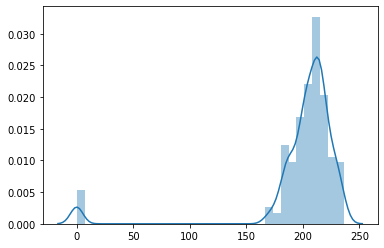

In [19]:
mask = np.where(states==1)
d = directions[mask]
sb.distplot(d.flatten())